In [ ]:
pip install pyod

In [31]:
import pandas as pd
from pyod.models.iforest import IForest
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [3]:
BIN_INTERVAL = '10min'
NUM_INTERVALS = 18

In [9]:
#The following part has been executed in a SWAN notebook in orde rto get data out from HDFS and store it in CSV
#Should be part of the notebook once the HDFS access and the Spark integration are in place
###
# df = spark.read.parquet("hdfs://analytix/project/monitoring/collectd/cpu/2021/04/*")
# monit_hdfssink = df.where("submitter_hostgroup == 'monitoring/flume/hdfssink/default' and submitter_environment == 'production' and type_instance == 'idle' and value is not null")
# monit_hdfssink_filtered = monit_hdfssink.select("timestamp", "host", "value")
# monit_hdfssink_filtered.toPandas().to_csv("/eos/home-n/ntsvetko/SWAN_projects/AnomalyDetection/cpu_idle.csv")
###

cpu_idle_df = pd.read_csv("/eos/user/n/ntsvetko/SWAN_projects/AnomalyDetection/cpu_idle.csv")

In [32]:
def preprocess_data(input_df, bin_interval, num_intervals):
    normalized_df = normalize_df(input_df)
    indata_imputated_df = data_imputation(normalized_df, bin_interval)
    return convert_into_2d_array(indata_imputated_df, num_intervals)

def normalize_df(input_df):
    df = pd.DataFrame(input_df)
    min = input_df.value.min()
    max = input_df.value.max()
    df['value_norm'] = (input_df['value'] - min) / (max - min)
    return df

def data_imputation(input_df, interval):
    input_df['datetime'] = pd.to_datetime(input_df['timestamp'],unit='ms')
    start_time = roundTime(input_df.datetime.min().to_pydatetime(), 10*60)
    end_time = roundTime(input_df.datetime.max().to_pydatetime(), 10*60)
    
    input_df.set_index('datetime', inplace=True)
    grouped_df = input_df.groupby([pd.Grouper(freq=interval),'host']).value.mean().to_frame()
    range_host_df = generate_range_host_df(input_df, start_time, end_time, interval)
    merged_df = range_host_df.merge(grouped_df, how='left', left_index=True, right_index=True)
    return merged_df.fillna(merged_df.mean())
    
    
def generate_range_host_df(input_df, start_time, end_time, interval):
    range_df = pd.date_range(start=start_time, end=end_time,freq=interval).to_frame(index=False, name='datetime')
    #host_df = pd.DataFrame(input_df['host'].unique(), columns = ['host'])
    range_host_df = pd.MultiIndex.from_product([range_df.datetime.to_list(), input_df['host'].unique()], names=["datetime", "host"])
    range_host_dff = pd.DataFrame(index = range_host_df).reset_index()
    range_host_dff.set_index(['datetime','host'], inplace=True)
    return range_host_dff

def convert_into_2d_array(input_df, num_intervals):
    result = []
    for v in input_df.groupby('host').value.apply(list):
        num_arrays = len(v) // num_intervals
        result += np.array_split(v[:num_arrays*num_intervals], num_arrays)
    return result

def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time lapse in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

In [50]:
full_set = preprocess_data(cpu_idle_df, BIN_INTERVAL, NUM_INTERVALS)

train_set = full_set[:int(len(full_set)*0.2)]
test_set = full_set[int(len(full_set)*0.8):]

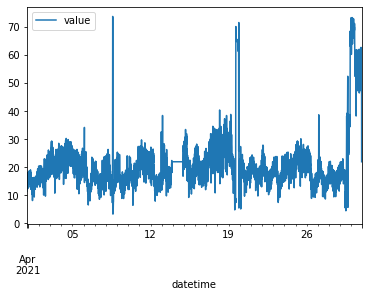

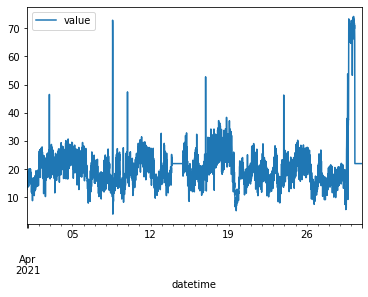

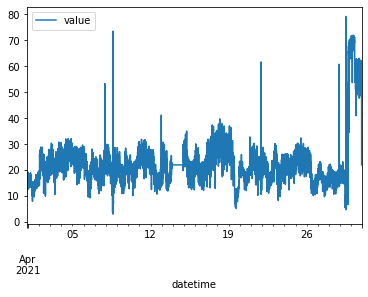

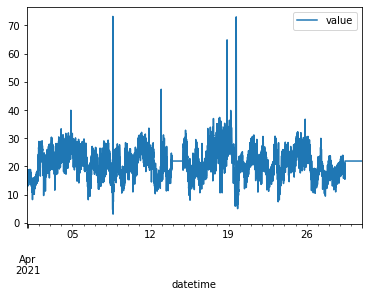

In [46]:
df = data_imputation(normalize_df(cpu_idle_df), BIN_INTERVAL)
for host in cpu_idle_df['host'].unique():
    plot_df = df.xs(host, level=1, drop_level=False)
    plot_dff = plot_df.droplevel(1)
    plot_dff.plot()
    plt.show()

In [51]:
clf = IForest()
clf.fit(train_set)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [52]:
clf.predict(test_set)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Deploying the model and creating InferenceService

from joblib import dump, load
import os
import boto3

# save the model
dump(clf_sklearn, '/home/jovyan/cpu_idle/model/model.joblib')

# uplload to S3
os.environ['S3_ENDPOINT'] = 'https://s3.cern.ch'
client = boto3.client('s3', endpoint_url='https://s3.cern.ch')
bucket = 'admon-is'
bucket_object = 'cpu_idle_model/1/model.joblib'
client.upload_file('/home/jovyan/cpu_idle/model/model.joblib', bucket, bucket_object)
